In [1]:
import math

import numpy as np
from cartopy import crs
from cartopy.feature import COLORS, NaturalEarthFeature
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from netCDF4 import Dataset
from scipy.interpolate import griddata
from wrf import (
    CoordPair,
    cartopy_xlim,
    cartopy_ylim,
    get_cartopy,
    getvar,
    interpline,
    latlon_coords,
    to_np,
    vertcross,
)

In [2]:
##function def part
cross_start = CoordPair(lat=41.2, lon=-106.56)
cross_end = CoordPair(lat=41.4, lon=-105.97)
def get(wrf_file,times):
    u = getvar(wrf_file, "ua",  timeidx = times)
    v = getvar(wrf_file, "va", timeidx = times)
    w = getvar(wrf_file, "wa", timeidx = times)
    ht = getvar(wrf_file, "z", timeidx=times)
    ter = getvar(wrf_file, "ter", timeidx=times)
    dbz = getvar(wrf_file, "REFL_10CM", timeidx=times)
    vice = getvar(wrf_file, "V_ICE", timeidx=times)
    qice = getvar(wrf_file, "QICE", timeidx=times)
    return u, v, w, ht, ter, dbz, vice,qice
def cross(x,des,uni):
    X = 10**(x/10)
    x_cross = vertcross(X, ht, wrfin=wrf_file_c,start_point=cross_start,end_point=cross_end,latlon=True,meta=True)
    x1_cross = 10.0 * np.log10(x_cross)
    x1_cross.attrs.update(x_cross.attrs)
    x1_cross.attrs["description"] = des
    x1_cross.attrs["units"] = uni
    x_cross_filled = np.ma.copy(to_np(x1_cross))
    for i in range(x_cross_filled.shape[-1]):
        column_vals = x_cross_filled[:,i]
        # Let's find the lowest index that isn't filled. The nonzero function
        # finds all unmasked values greater than 0. Since 0 is a valid value
        # for dBZ, let's change that threshold to be -200 dBZ instead.
        first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
        x_cross_filled[0:first_idx, i] = 0
    return x_cross_filled,x1_cross
def diff(c, t):
    acc_percent = np.empty(shape = np.shape(c))
    acc_percent[:, :] = 100*(t[:, :]-c[:, :])/c[:, :]
    acc_percent[np.isinf(acc_percent)]=0
    acc_percent = np.nan_to_num(acc_percent)
    return acc_percent

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


saving1900UTC...


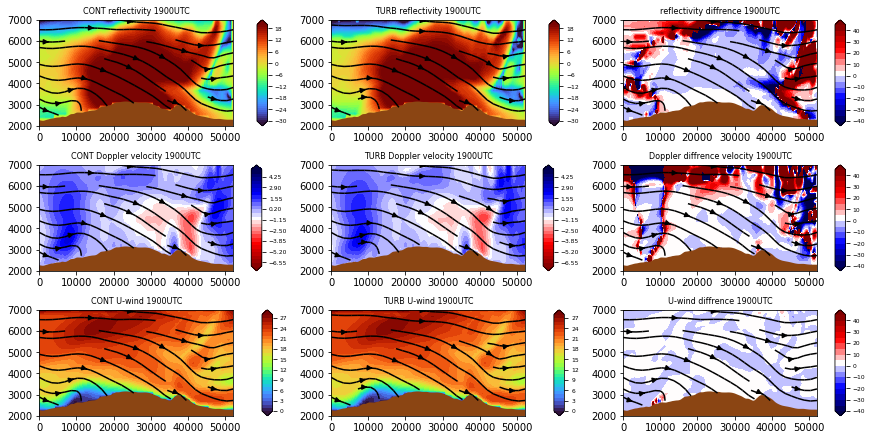

In [7]:
for i in range(19, 20):
    for j in range(0,1):
        if i==18:
            times_t = j
            times_c = j
            timeout = j+12
        elif i==19:
            times_t = j
            times_c = j
            timeout = j
       #wrf_file_t = Dataset("/glade/scratch/mingzhu/High_res/WRF/300out_turb_sierra/wrfout_d03_2006-01-18_12:00:00")
       #wrf_file_c = Dataset("/glade/scratch/mingzhu/High_res/WRF/300out_cont_sierra/wrfout_d03_2006-01-18_12:00:00")
        wrf_file_t = Dataset("/glade/scratch/mingzhu/High_res/WRF_test/run_mynn_turb/wrfout_d03_2006-01-19_00:00:00")
        wrf_file_c = Dataset("/glade/scratch/mingzhu/High_res/WRF_test/run_mynn_cont/wrfout_d03_2006-01-19_00:00:00")
        angle = math.radians(14)
        u, v, w, ht, ter, dbz, vice,qice = get(wrf_file_c,times_c)
        u_t, v_t, w_t, ht_t, ter_t, dbz_t, vice_t,qice_t = get(wrf_file_t,times_t)
        #############The developed parameter by Zach############
        tkegr = getvar(wrf_file_c, "TKE_GR", timeidx=times_c)[:119, :, :]   #
        tkegr_t = getvar(wrf_file_t, "TKE_GR", timeidx=times_t)[:119, :, :] #
        urms = getvar(wrf_file_c, 'URMS', timeidx = times_c)   #
        urms_t = getvar(wrf_file_t, 'URMS', timeidx = times_t)#
        tke = getvar(wrf_file_c, 'TKE', timeidx = times_c)[:119, :, :]
        tke_t = getvar(wrf_file_t, 'TKE', timeidx = times_t)[:119, :, :]
        dbz,dbz1 = cross(dbz,'reflectivity', 'dBZ')
        ua = cross(u,'U-wind', 'm/s')[0]
        va = cross(v,'V-wind', 'm/s')[0]
        wa = cross(w,'W-wind', 'm/s')[0]
        vice = cross(vice,'Ice Falling Speed','m/s')[0]
        qice = cross(qice,'Ice mixing ratio','kg kg-1')[0]
        dbz_t,dbz1_t = cross(dbz_t,'reflectivity', 'dBZ')
        ua_t = cross(u_t,'U-wind', 'm/s')[0]
        va_t = cross(v_t,'V-wind', 'm/s')[0]
        wa_t = cross(w_t,'W-wind', 'm/s')[0]
        vice_t = cross(vice_t,'Ice Falling Speed','m/s')[0]
        qice_t = cross(qice_t,'Ice mixing ratio','kg kg-1')[0]
        tke = cross(tke, 'tke cont', '')[0]
        tkegr = cross(tkegr, 'tkegr cont', '')[0]
        tke_t = cross(tke_t, 'tke turb', '')[0]
        tkegr_t = cross(tkegr_t, 'tkegr turb', '')[0]
        urms = cross(urms, 'rms speed cont', '')[0]
        urms_t = cross(urms_t, 'rms speed turb', '')[0]
        ############
        dopp = to_np(wa-vice)
        hori = ua * math.cos(angle)
        stream = to_np(ua * math.cos(angle) + va * math.sin(angle))
        dopp_t = to_np(wa_t-vice_t)
        hori_t = ua_t * math.cos(angle)
        stream_t = to_np(ua_t * math.cos(angle) + va_t * math.sin(angle))
        dbz_diff = diff(dbz, dbz_t)
        dopp_diff = diff(dopp, dopp_t)
        hori_diff = diff(hori,hori_t)
        vice_diff = diff(vice, vice_t)
        qice_diff = diff(qice, qice_t)
        tke_diff = diff(tke, tke_t)
        tkegr_diff = diff(tkegr, tkegr_t)
        urms_diff = diff(urms, urms_t)
        ter_line = interpline(ter, wrfin=wrf_file_c, start_point=cross_start,
                      end_point=cross_end)
        lats, lons = latlon_coords(u)
        cart_proj = get_cartopy(u)
        fig, ((ax_ref,ax_ref_t,ax_ref_diff)
              ,(ax_w,ax_w_t,ax_w_diff)
             ,(ax_hori,ax_hori_t,ax_hori_diff)
             #,(ax_vice, ax_vice_t, ax_vice_diff)
             #,(ax_q, ax_q_t, ax_q_diff)
             #(ax_tke, ax_tke_t, ax_tke_diff)
             #,(ax_rms, ax_rms_t, ax_rms_diff)
             #,(ax_tkegr, ax_tkegr_t, ax_tkegr_diff)
             ) = pyplot.subplots(3,3,figsize=(12,6),constrained_layout=True)
        xs = np.arange(0, dbz1.shape[-1], 1)*300
        ys = to_np(dbz1.coords["vertical"])
    
        def crossplot(cname, x, y, z, hori, ver, levels, colors, title):
                      var_fill = cname.contourf(x,y,z, levels = levels, cmap=get_cmap(colors), extend = 'both')
                      ht_fill = cname.fill_between(x, 0, to_np(ter_line),facecolor="saddlebrown")
                      cname.set_ylim([0, 7000])
                      cname.set_title(title, fontsize=8)
                      cb_cross = fig.colorbar(var_fill, ax=cname)
                      cb_cross.ax.tick_params(labelsize=6)
                      s1 = cname.streamplot(to_np(x), to_np(y),
                                            hori,
                                            ver,
                                            color = 'k')
                      cname.set_ylim([2000, 7000])
        crossplot(ax_ref,xs,ys,dbz,stream,dopp,np.arange(-30., 21, 1),"turbo",'CONT reflectivity %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_w,xs,ys,wa,stream,dopp,np.arange(-7., 5.45, .45),"seismic_r",'CONT Doppler velocity %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_hori,xs,ys,hori,stream,dopp,np.arange(0., 29., 1.),"turbo",'CONT U-wind %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_vice,xs,ys,vice,stream,dopp,np.arange(0,2,.1),"autumn_r",'CONT Vice %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_q,xs,ys,qice*1000,stream,dopp,np.arange(0,0.5,.05),"BuGn",'CONT Qice %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_tke,xs,ys,tke,stream,dopp,np.arange(0,.5,.05),"RdPu",'CONT TKE %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_rms,xs,ys,urms,stream,dopp,np.arange(0,5,.5),"YlGnBu",'CONT URMS %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_tkegr,xs,ys,tkegr,stream,dopp,np.arange(0,5,.5),"RdPu",'CONT TKE %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #
        crossplot(ax_ref_t,xs,ys,dbz_t,stream,dopp_t,np.arange(-30., 21, 1),"turbo",'TURB reflectivity %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_w_t,xs,ys,wa_t,stream,dopp_t,np.arange(-7., 5.45, .45),"seismic_r",'TURB Doppler velocity %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_hori_t,xs,ys,hori,stream,dopp_t,np.arange(0., 29., 1.),"turbo",'TURB U-wind %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_vice_t,xs,ys,vice_t,stream,dopp_t,np.arange(0,2,.1),"autumn_r",'TURB Vice %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_q_t,xs,ys,qice_t*1000,stream,dopp_t,np.arange(0,0.5,.05),"BuGn",'TURB Qice %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_tke_t,xs,ys,tke_t,stream,dopp,np.arange(0,.5,.05),"RdPu",'TURB TKE %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_rms_t,xs,ys,urms_t,stream,dopp,np.arange(0,5,.5),"YlGnBu",'TURB URMS %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_tkegr_t,xs,ys,tkegr_t,stream,dopp,np.arange(0,5,.5),"RdPu",'TURB TKE %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #
        acclevel = np.arange(-40, 50, 5)
        crossplot(ax_ref_diff,xs,ys,dbz_diff,stream,dopp,acclevel,"seismic",'reflectivity diffrence %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_w_diff,xs,ys,dopp_diff,stream,dopp,acclevel,"seismic",'Doppler diffrence velocity %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_hori_diff,xs,ys,hori_diff,stream,dopp,acclevel,"seismic",'U-wind diffrence %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_vice_diff,xs,ys,vice_diff,stream,dopp,acclevel,"seismic",'Vice diffrence %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_q_diff,xs,ys,qice_diff,stream,dopp,acclevel,"seismic",'Qice difference %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_tke_diff,xs,ys,tke_diff,stream,dopp,acclevel,"seismic",'TKE diffrence %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_rms_diff,xs,ys,urms_diff,stream,dopp,acclevel,"seismic",'RMS difference %02d' % (i) + '%02d' % (timeout) + 'UTC')
        #crossplot(ax_tkegr_diff,xs,ys,tkegr_diff,stream,dopp,acclevel,"seismic",'TKEGR difference %02d' % (i) + '%02d' % (timeout) + 'UTC')
        
        print('saving%02d' % (i) + '%02d' % (timeout) + 'UTC...')
        #pyplot.savefig('cross_sec/MYNNmedtke_comparediff_ref_ice%02d'% (i) + '%02d' % (timeout) + '.png')